In [ ]:
import os
import sys
import time
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms

!cp -av '/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection' .
time.sleep(2)

from pytorch_detection import utils
os.chdir('pytorch_detection')
from pytorch_detection import transforms as T
from pytorch_detection import coco_eval
from pytorch_detection import coco_utils
from pytorch_detection.prediction_box import showbbox
from pytorch_detection.engine import train_one_epoch, evaluate
from pytorch_detection.preprocess_model import MarkDataset, get_transform, get_object_detection_model, RandomHorizontalFlip
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
os.chdir('..')

'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection' -> './pytorch_detection'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/engine.py' -> './pytorch_detection/engine.py'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/utils.py' -> './pytorch_detection/utils.py'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/transforms.py' -> './pytorch_detection/transforms.py'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/coco_eval.py' -> './pytorch_detection/coco_eval.py'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/coco_utils.py' -> './pytorch_detection/coco_utils.py'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/prediction_box.py' -> './pytorch_detection/prediction_box.py'
'/content/drive/My Drive/Hackathon_R-CNN/pytorch_detection/preprocess_model.py' -> './pytorch_detection/preprocess_model.py'


In [ ]:
num_classes = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
root = r'/content/drive/My Drive/Hackathon_R-CNN/InsulatorDataSet_changed/' 
dataset = MarkDataset(root, get_transform(train=True))
dataset_test = MarkDataset(root, get_transform(train=False))

In [ ]:
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices)

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, # num_workers=4,
    collate_fn=utils.collate_fn)

# subroots = ['/Defective_Insulators', '/Normal_Insulators']

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
# Num_when training models in jupyter notebook The workers parameter can only be 0, otherwise an error will occur, which is commented out here
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, # num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, # num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:


# get the model using our helper function
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0003,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
# cos learning rate
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# let's train it for   epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    # Engine.pyTrain_ofOne_The epoch function takes both images and targets. to(device)
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset    
    evaluate(model, data_loader_test, device=device)    
    
    print('')
    print('==================================================')
    print('')


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [  0/374]  eta: 0:05:36  lr: 0.000001  loss: 1.3949 (1.3949)  loss_classifier: 0.6548 (0.6548)  loss_box_reg: 0.0057 (0.0057)  loss_objectness: 0.6959 (0.6959)  loss_rpn_box_reg: 0.0384 (0.0384)  time: 0.9005  data: 0.1692  max mem: 2133
Epoch: [0]  [ 50/374]  eta: 0:03:47  lr: 0.000041  loss: 1.3587 (1.4243)  loss_classifier: 0.6089 (0.6330)  loss_box_reg: 0.0006 (0.0054)  loss_objectness: 0.6941 (0.6946)  loss_rpn_box_reg: 0.0496 (0.0914)  time: 0.6852  data: 0.1591  max mem: 2398
Epoch: [0]  [100/374]  eta: 0:03:12  lr: 0.000081  loss: 1.1013 (1.3352)  loss_classifier: 0.3347 (0.5383)  loss_box_reg: 0.0072 (0.0071)  loss_objectness: 0.6912 (0.6934)  loss_rpn_box_reg: 0.0912 (0.0964)  time: 0.6989  data: 0.1758  max mem: 2398
Epoch: [0]  [150/374]  eta: 0:02:36  lr: 0.000122  loss: 0.9808 (1.2120)  loss_classifier: 0.2182 (0.4197)  loss_box_reg: 0.0129 (0.0094)  loss_objectness: 0.6639 (0.6879)  loss_rpn_box_reg: 0.0692 (0.0952)  time: 0.7208  data: 0.1947  max mem: 2398


In [ ]:
torch.save(model, r'R_CNN_ResNet.pkl')
time.sleep(30)

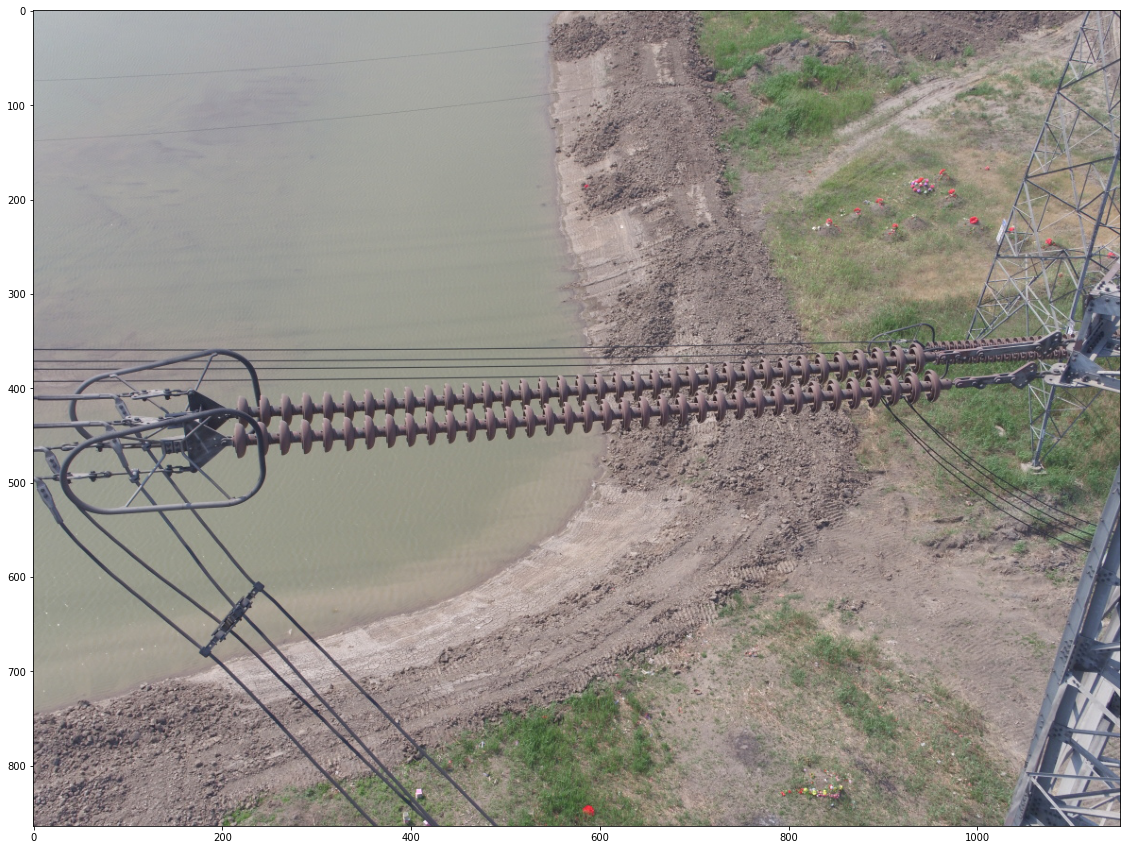

In [ ]:
model = torch.load(r'R_CNN_ResNet.pkl')
model.to(device)

img, _ = dataset_test[9] 
showbbox(model, img)